In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import math

## Importing the drivingProfile

In [2]:
drivingProfile = pd.read_csv('./parameter.csv')

In [3]:
drivingProfile

,m,lf,lr,Cf,Cr,Iz,mu,steering_ratio,Sampling Period
0,1331,0.84,1.63,90624,90624,1500,0.5,0.0625,0.04


In [4]:
m = drivingProfile['m'][0]
lf = drivingProfile['lf'][0]
lr = drivingProfile['lr'][0]
Cf = drivingProfile['Cf'][0]
Cr = drivingProfile['Cr'][0]
Iz = drivingProfile['Iz'][0]
steering_ratio = drivingProfile['steering_ratio'][0]
Ts = drivingProfile['Sampling Period'][0]

## Importing inputs

In [5]:
inputs = pd.read_csv('./input2.csv')
inputs.head()

,samplingTime,DRV_DeltaSteer,Veh_Vx
0,0.000,0.0,30.000000
1,0.005,0.0,29.999664
2,0.010,0.0,29.998813
3,0.015,0.0,29.997596
4,0.020,0.0,29.996121


In [6]:
Time = inputs['samplingTime'].to_numpy()

print(Time)
print(len(Time))

deltaSteer = inputs['DRV_DeltaSteer'].to_numpy()

print(deltaSteer)
print(len(deltaSteer))

Vx = inputs['Veh_Vx'].to_numpy()

print(Vx)
print(len(Vx))

[0.000e+00 5.000e-03 1.000e-02 ... 9.990e+00 9.995e+00 1.000e+01]
2001
[0. 0. 0. ... 0. 0. 0.]
2001
[30.         29.99966417 29.99881271 ... 22.40103788 22.39962281
 22.39820783]
2001


In [7]:
n = math.floor(Ts/(Time[1]-Time[0]))
n

8

In [8]:
time = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity = [Vx[i] for i in range(len(Vx)) if i%n==0]

## Function to calculate parameters

In [9]:
def calculate_parameters(v_x):
  A = np.array([[(-2*Cf-2*Cr)/(m*v_x), -1-((2*Cf*lf - 2*Cr*lr)/(m*v_x*v_x))], [((2*Cr*lr)-(2*Cf*lf))/Iz, (-2*Cf*lf*lf-2*Cr*lr*lr)/(Iz*v_x)]])
  B = np.array([[(2*Cf)/(m*v_x), 0], [(2*Cf*lf)/Iz, 1/Iz]])
  C = np.array([[0, 1], [(-2*Cf-2*Cr)/m, -(2*Cf*lf-2*Cr*lr)/(m*v_x)]])
  D = np.array([[0, 0], [(2*Cf)/m, 0]])

  return [A, B, C, D]

## Controller Gain K

In [10]:
K = np.array([[1.8639, -0.0279],[-542794.8896, 32604.6225]])

## Observer Gain L

In [11]:
L = np.array([[-0.000000000009229, -0.000000000131049],[0.000000000135782, 0.000000001407986]])

## Matrix P
Positive definite P such that:  
![](./Screenshot%202023-05-30%20104347.png)  
`Amin, Amax` => Discrete-time closed loop matrices derived using the system equations fror v = vmin and v = vmax respectively.

In [12]:
P = np.array([[2, 1],[1,1]])
P

array([[2, 1],
       [1, 1]])

## Evaluating the system

In [13]:
u = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x = [np.dot(np.linalg.inv(-K), u[0])]
x_cap = [np.dot(np.linalg.inv(-K), u[0])]
A, B, C, D = calculate_parameters(max(Vx))
y = [np.dot(C,x[0])]
y_cap = [np.dot(C,x_cap[0])]

for i in range(1, len(velocity)):
  A, B, C, D = calculate_parameters(velocity[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y[i-1] - y_cap[i-1]

  x.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1])))
  x_cap.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1]))+np.dot(L,r))

  y.append(np.dot(out.C, x[i-1])+np.dot(out.D, u[i-1]))
  y_cap.append(np.dot(out.C, x_cap[i-1])+np.dot(out.D, u[i-1]))

  utemp = np.dot(-K, x[i])
  utemp[0][0] += steeringAngle[i]*(math.pi/180)*steering_ratio
  u.append(utemp)

## Extracting the values from the lists

### Extracting `yaw moment -> Mz` and `steering angle -> beta` from `u[]`

In [14]:
Mz = []
delta = []
for i in range(len(u)):
    Mz.append(u[i][1][0])
    delta.append(u[i][0][0])
print(len(Mz), len(delta))
print(Mz)
print(delta)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -338.89699078337793, -1137.501525584509, -2070.2958345510006, -3013.0265019261687, -3950.206082020119, -4883.052797935337, -5811.721259356526, -6735.175648854156, -6983.4046193072245, -6987.1714830972005, -6961.732095305947, -6936.670754190812, -6903.308765963714, -5548.921559875303, -3731.9558611268644, -1894.0139435084816, -96.20471062956237, 1673.3221661815055, 3426.884540156196, 5163.267712609073, 6264.906661295207, 6514.658733236362, 6502.205998803286, 6450.217104581384, 6384.017788985428, 6009.307326176256, 5227.020582680484, 4336.864162577966, 3466.9066542625283, 2625.5375151396306,

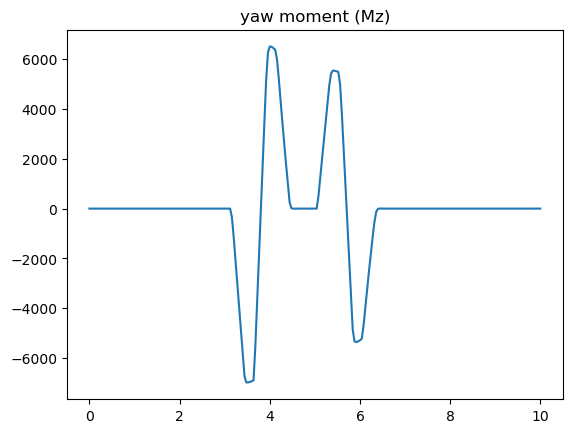

Text(0.5, 1.0, 'steering angle (delta)')

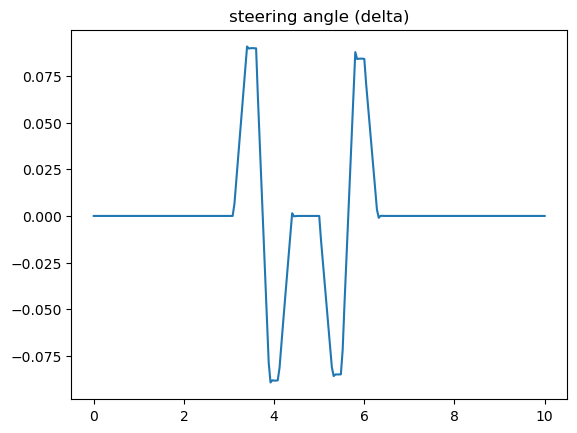

In [15]:
plt.plot(time, Mz)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time, delta)
plt.title("steering angle (delta)")

### Extracting `sideslip angle -> beta` and `yaw rate -> r` from `x[] and x_cap[]`

In [16]:
'''
0 -> beta
1 -> r
'''
r = []
beta = []

for i in range(len(x)):
    r.append(x[i][1][0])
    beta.append(x[i][0][0])

print(len(beta), len(r))
print(beta)
print(r)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006744893095260035, 0.0020455620963549417, 0.003415329385455656, 0.004757406153899388, 0.00609667625311669, 0.007441087583019784, 0.008792784862353305, 0.010153703819124405, 0.010163443783707485, 0.010133901894338153, 0.01015576721469306, 0.01019624595929677, 0.010252597023939856, 0.007560008058174041, 0.004744696007490669, 0.0019701387542949873, -0.0008388334816956048, -0.0036963936783754978, -0.0065908565979282885, -0.00951924360536623, -0.011040061453474798, -0.011059542179734176, -0.011051861788530801, -0.011114488463920871, -0.01121962891879704, -0.010613756195360098, -0.0092289284

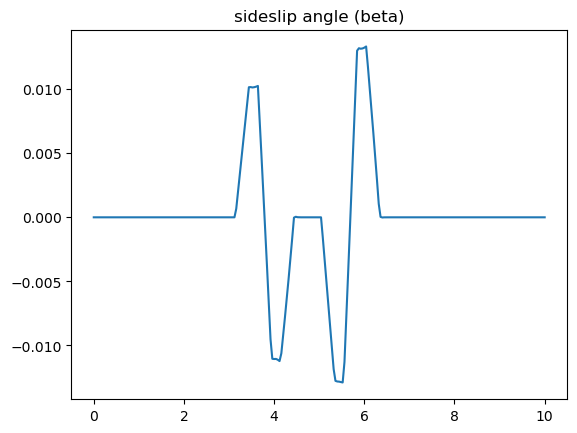

Text(0.5, 1.0, 'yaw rate (r)')

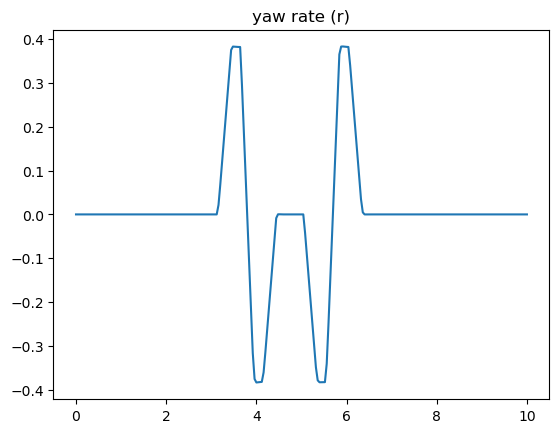

In [17]:
plt.plot(time, beta)
plt.title("sideslip angle (beta)")
plt.show()
plt.plot(time, r)
plt.title("yaw rate (r)")

In [18]:
'''
0 -> beta
1 -> r
'''
r_cap = []
beta_cap = []
for i in range(len(x)):
    r_cap.append(x_cap[i][1][0])
    beta_cap.append(x_cap[i][0][0])

print(len(beta_cap), len(r_cap))
print(beta_cap)
print(r_cap)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006744893095260035, 0.0020455620963549417, 0.003415329385455656, 0.004757406153899388, 0.00609667625311669, 0.007441087583019784, 0.008792784862353305, 0.010153703819124405, 0.010163443783707485, 0.010133901894338153, 0.01015576721469306, 0.01019624595929677, 0.010252597023939856, 0.007560008058174041, 0.004744696007490669, 0.0019701387542949873, -0.0008388334816956048, -0.0036963936783754978, -0.0065908565979282885, -0.00951924360536623, -0.011040061453474798, -0.011059542179734176, -0.011051861788530801, -0.011114488463920871, -0.01121962891879704, -0.010613756195360098, -0.0092289284

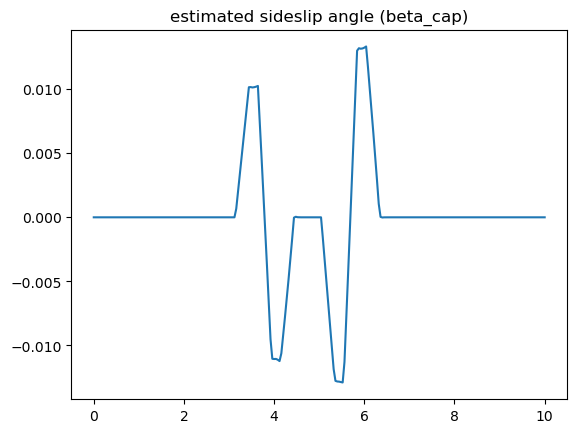

Text(0.5, 1.0, 'estaimated yaw rate (r_cap)')

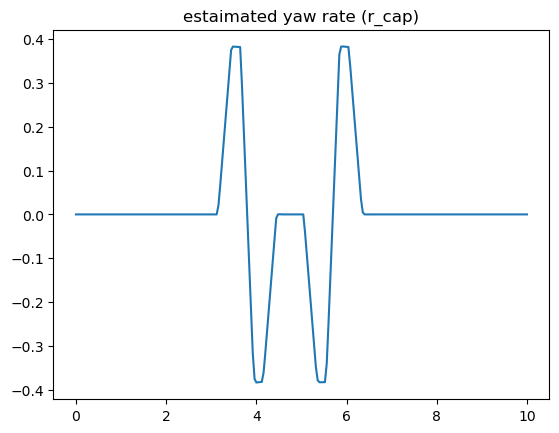

In [19]:
plt.plot(time, beta)
plt.title("estimated sideslip angle (beta_cap)")
plt.show()
plt.plot(time, r)
plt.title("estaimated yaw rate (r_cap)")

### Extracting `yaw rate -> r` and `inertial acceleration -> ay` from `y[] and y_cap[]`

In [20]:
'''
0 -> r
1 -> ay
'''
r1 = []
ay = []
for i in range(len(y)):
    r1.append(y[i][0][0])
    ay.append(y[i][1][0])

print(len(r1), len(ay))
print(r1)
print(ay)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021622895375768426, 0.06894182497728456, 0.1203546880899185, 0.17161131830354262, 0.2226509690691108, 0.27364331885960314, 0.32462881445703407, 0.3756079124175379, 0.38338336736886114, 0.38300709180275616, 0.3825908623664809, 0.3824961001772601, 0.38241099205140117, 0.296045608231992, 0.19344964373374735, 0.0908888054490651, -0.011014076806446296, -0.11285840726275764, -0.2148274472307757, -0.31683435360919576, -0.37594042375774406, -0.3839247551389904, -0.38341496204053027, -0.3828630324830716, -0.3825830226777456, -0.3610040247660606, -0.31395657984856395, -0.26278935685397925, -0

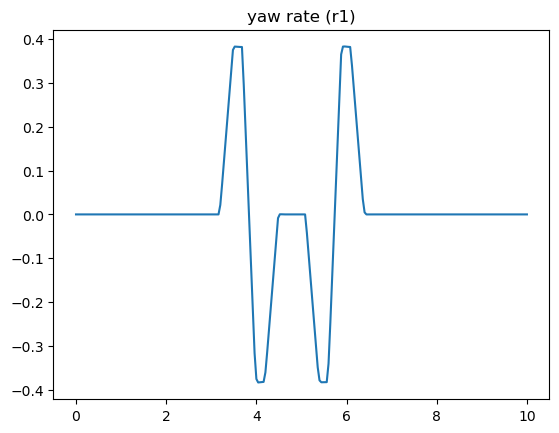

Text(0.5, 1.0, 'inertial acceleration (ay)')

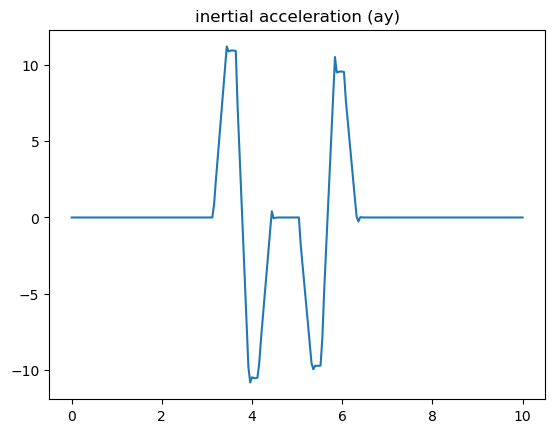

In [21]:
plt.plot(time, r1)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("inertial acceleration (ay)")

In [22]:
'''
0 -> r1
1 -> ay
'''
r1_cap = []
ay_cap = []
for i in range(len(y_cap)):
    r1_cap.append(y_cap[i][1][0])
    ay_cap.append(y_cap[i][0][0])

print(len(r1_cap), len(ay_cap))
print(r1_cap)
print(ay_cap)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8912587422956468, 2.481859227452582, 3.899761452290072, 5.349444770523026, 6.812798814568839, 8.276338637289205, 9.737262956884553, 11.194882724521618, 10.865803310681315, 10.921564395215642, 10.936562480045414, 10.924616622704843, 10.906456284923093, 7.316728352327922, 4.517282373752454, 1.6553052293965302, -1.231823258589701, -4.099418458532193, -6.943338785938271, -9.77100339283025, -10.800877547328415, -10.45957017795604, -10.51455316328635, -10.52007032634322, -10.490491848183204, -9.551481184600304, -7.930926381935535, -6.520086914779037, -5.0990366994441745, -3.6899437772803756, -

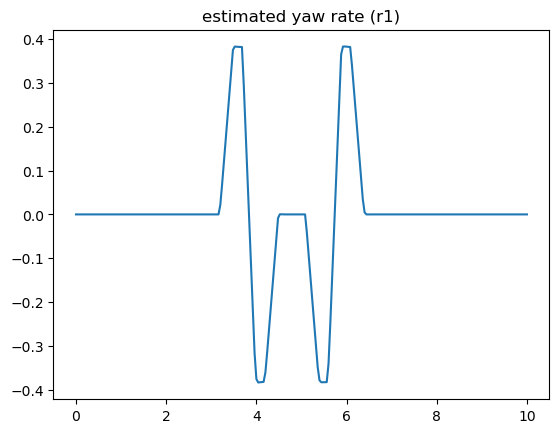

Text(0.5, 1.0, 'estimated inertial acceleration (ay)')

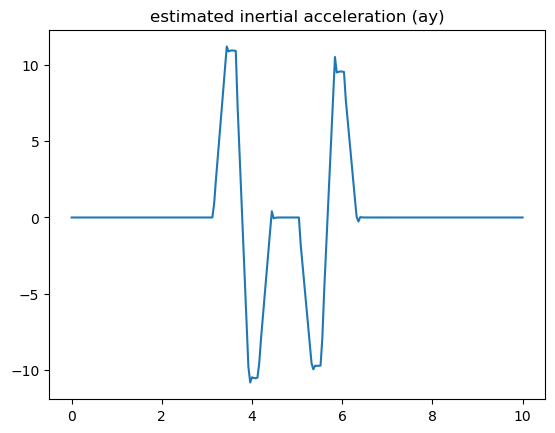

In [23]:
plt.plot(time, r1)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("estimated inertial acceleration (ay)")

---

## Inputs and Outputs

In [24]:
inputs = [[], []]

for i in range(len(u)):
    inputs[0].append(u[i][0][0])
    inputs[1].append(u[i][1][0])

inputs = np.array(inputs)

In [25]:
outputs = [[], []]

for i in range(len(y)):
    outputs[0].append(y[i][0][0])
    outputs[1].append(y[i][1][0])

outputs = np.array(outputs)

# Inserting noise to the output data

In [26]:
from sippy import functionset as fset

In [27]:
size = len(inputs[0])
noise = fset.white_noise_var(size, [0.001, 0.01])

In [28]:
netOuput = outputs + noise

In [29]:
netOuput.shape

(2, 251)

---

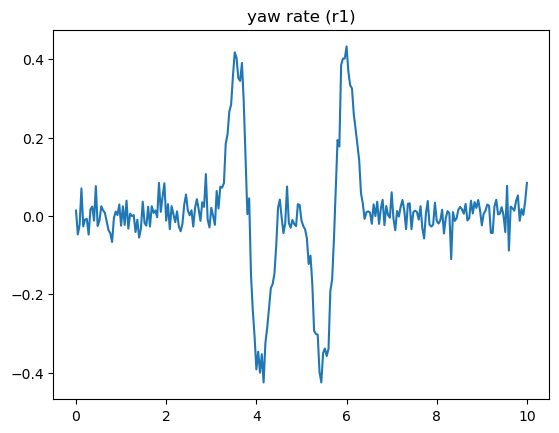

Text(0.5, 1.0, 'inertial acceleration (ay)')

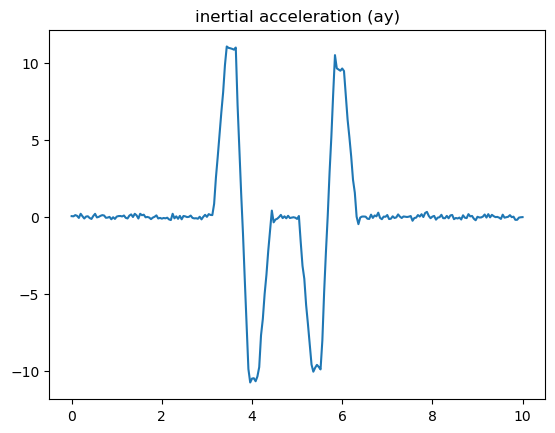

In [30]:
plt.plot(time, netOuput[0])
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, netOuput[1])
plt.title("inertial acceleration (ay)")

---
---

# SYSTEM IDENTIFICATION USING **SIPPY**

In [31]:
from sippy import system_identification
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## Using State-Space form

In [32]:
METHOD = [
    'N4SID',
    'CVA', 
    'MOESP', 
    'PARSIM-S', 
    'PARSIM-P', 
    'PARSIM-K'
    ]

lege = ['System']

In [33]:
sysId = system_identification(netOuput, inputs, METHOD[1])

In [34]:
x_id, y_id = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs, sysId.x0)

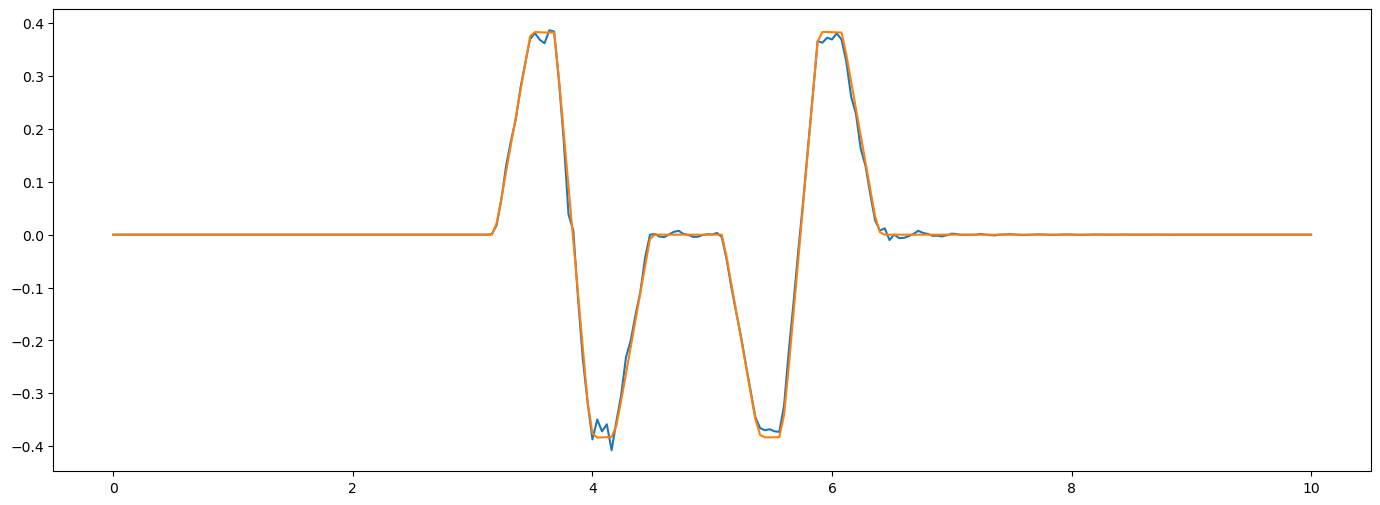

In [35]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id[0])
plt.plot(time, outputs[0])

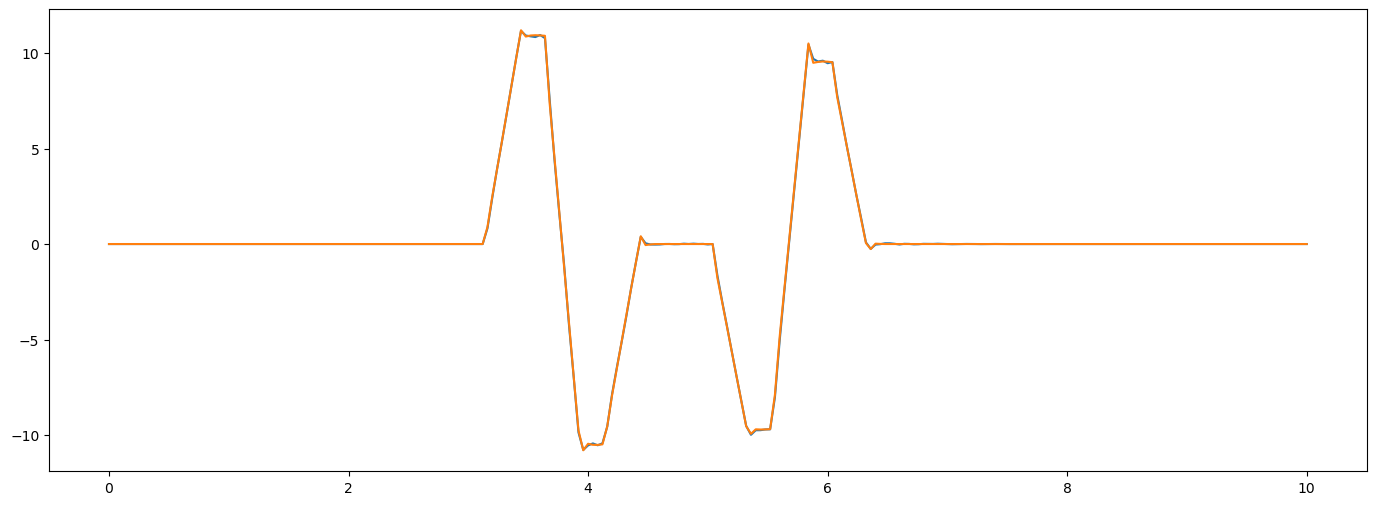

In [36]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id[1])
plt.plot(time, outputs[1])

In [37]:
# for yaw rate
r2_score(netOuput[0], y_id[0])

0.9505763134534657

In [38]:
# for inretial acceleration ay
r2_score(netOuput[1], y_id[1])

0.9991737968021869

---

In [39]:
# for yaw rate
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.03178219085527063

In [40]:
# for inretial acceleration ay
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.03178219085527063

---
# Circular Maneuver
---

In [41]:
circular_data = pd.read_csv('./Circular maneuver/circular_input.csv')
circular_data.head()

,samplingTime,Drv_DeltaSteer,Veh_Vx
0,0.000,0.0,30.000000
1,0.005,0.0,29.999664
2,0.010,0.0,29.998813
3,0.015,0.0,29.997596
4,0.020,0.0,29.996121


In [42]:
Time = circular_data['samplingTime'].to_numpy()

deltaSteer = circular_data['Drv_DeltaSteer'].to_numpy()

Vx = circular_data['Veh_Vx'].to_numpy()

n = math.floor(Ts/(Time[1]-Time[0]))

time_circular = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle_circular = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity_circular = [Vx[i] for i in range(len(Vx)) if i%n==0]

In [43]:
u_circular = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x_circular = [np.dot(np.linalg.inv(-K), u[0])]
x_cap_circular = [np.dot(np.linalg.inv(-K), u[0])]
A, B, C, D = calculate_parameters(max(Vx))
y_circular = [np.dot(C,x[0])]
y_cap_circular = [np.dot(C,x_cap[0])]

for i in range(1, len(velocity_circular)):
  A, B, C, D = calculate_parameters(velocity_circular[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y_circular[i-1] - y_cap_circular[i-1]

  x_circular.append(np.array(np.dot(out.A, x_circular[i-1])+np.dot(out.B, u_circular[i-1])))
  x_cap_circular.append(np.array(np.dot(out.A, x_circular[i-1])+np.dot(out.B, u_circular[i-1]))+np.dot(L,r))

  y_circular.append(np.dot(out.C, x_circular[i-1])+np.dot(out.D, u_circular[i-1]))
  y_cap_circular.append(np.dot(out.C, x_cap_circular[i-1])+np.dot(out.D, u_circular[i-1]))

  utemp = np.dot(-K, x_circular[i])
  utemp[0][0] += steeringAngle_circular[i]*(math.pi/180)*steering_ratio
  u_circular.append(utemp)

In [44]:
Mz_circular = []
delta_circular = []
for i in range(len(u_circular)):
    Mz_circular.append(u_circular[i][1][0])
    delta_circular.append(u_circular[i][0][0])
print(len(Mz_circular), len(delta_circular))
print(Mz_circular)
print(delta_circular)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.3715422312786493e-12, -652.9832567487384, -1531.389209292028, -2420.648933596294, -3292.26591298289, -4159.198850270486, -5021.211229971462, -5873.258033015869, -6407.227717041457, -6518.057907765396, -6497.626706471233, -6449.140571287714, -6383.963322055539, -5715.335047807089, -4246.3881298248225, -2568.7674671478667, -926.0095883639517, -489.9014916690421, -1000.0540858566981, -1743.3253999845942, -2510.832290783048, -3271.3149575217335, -4029.2281611332323, -4786.42239186119, -5478.443282683864, -5692.199994963506, -5704.6

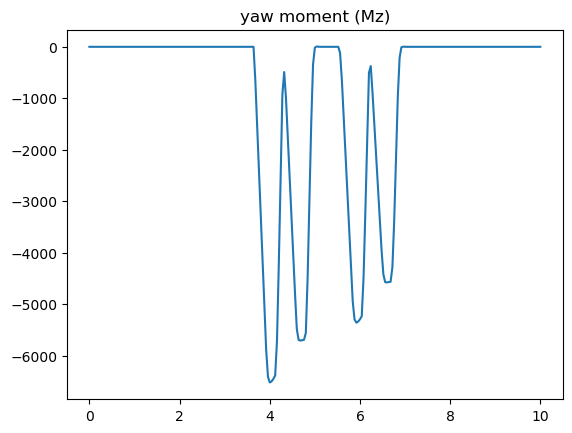

Text(0.5, 1.0, 'steering angle (delta)')

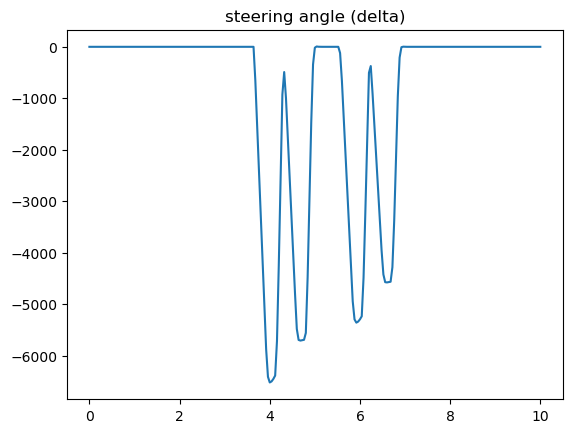

In [45]:
plt.plot(time_circular, Mz_circular)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time_circular, Mz_circular)
plt.title("steering angle (delta)")

In [46]:
inputs_circular = [[], []]

for i in range(len(u_circular)):
    inputs_circular[0].append(u_circular[i][0][0])
    inputs_circular[1].append(u_circular[i][1][0])

inputs_circular = np.array(inputs_circular)

In [47]:
'''
0 -> r
1 -> ay
'''
r1_circular = []
ay_circular = []

for i in range(len(y_circular)):
    r1_circular.append(y_circular[i][0][0])
    ay_circular.append(y_circular[i][1][0])

print(len(r1_circular), len(ay_circular))
print(r1_circular)
print(ay_circular)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.98758298624351e-17, 0.043111373444383934, 0.09435314984722701, 0.14564968242799745, 0.19665781338584748, 0.24771699605598058, 0.2987881247797913, 0.34981441416986986, 0.3793785661290292, 0.3834143950090267, 0.38317981248140665, 0.3828328032488783, 0.38258533444117737, 0.3396259784810944, 0.2457096827657748, 0.14347075410364057, 0.04144666611708657, 0.030028168473299737, 0.07366726215970369, 0.12521079625212442, 0.17672790951270206, 0.22790741385208266, 0.27903736838217047, 0.33017121709943814, 0.3760082013532961, 0.38369500

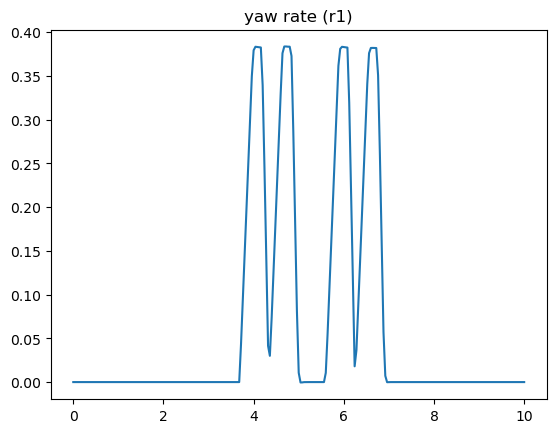

Text(0.5, 1.0, 'inertial acceleration (ay)')

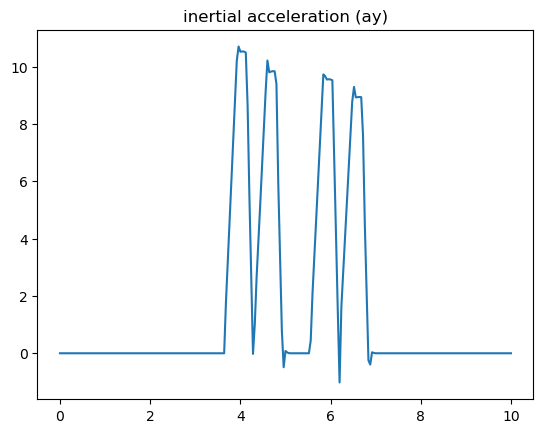

In [48]:
plt.plot(time, r1_circular)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, ay_circular)
plt.title("inertial acceleration (ay)")

In [49]:
'''
0 -> r1
1 -> ay
'''
r1_cap = []
ay_cap = []

for i in range(len(y_cap)):
    r1_cap.append(y_cap[i][1][0])
    ay_cap.append(y_cap[i][0][0])

print(len(r1_cap), len(ay_cap))
print(r1_cap)
print(ay_cap)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8912587422956468, 2.481859227452582, 3.899761452290072, 5.349444770523026, 6.812798814568839, 8.276338637289205, 9.737262956884553, 11.194882724521618, 10.865803310681315, 10.921564395215642, 10.936562480045414, 10.924616622704843, 10.906456284923093, 7.316728352327922, 4.517282373752454, 1.6553052293965302, -1.231823258589701, -4.099418458532193, -6.943338785938271, -9.77100339283025, -10.800877547328415, -10.45957017795604, -10.51455316328635, -10.52007032634322, -10.490491848183204, -9.551481184600304, -7.930926381935535, -6.520086914779037, -5.0990366994441745, -3.6899437772803756, -

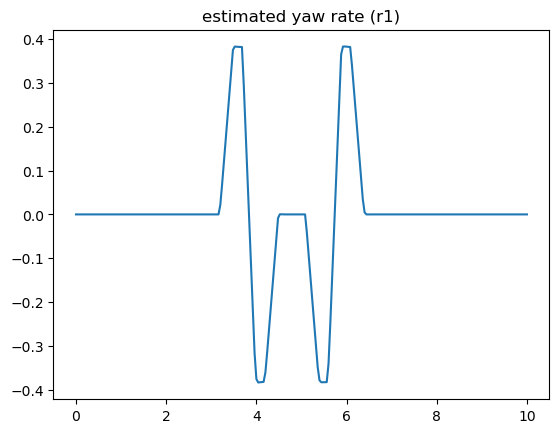

Text(0.5, 1.0, 'estimated inertial acceleration (ay)')

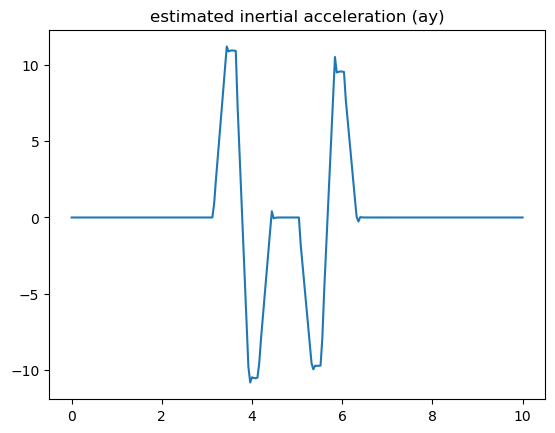

In [50]:
plt.plot(time, r1)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("estimated inertial acceleration (ay)")

In [51]:
outputs_circular = [[], []]

for i in range(len(y_circular)):
    outputs_circular[0].append(y_circular[i][0][0])
    outputs_circular[1].append(y_circular[i][1][0])

outputs_circular = np.array(outputs_circular)

In [52]:
x_id_circular, y_id_circular = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs_circular, sysId.x0)

Text(0.5, 1.0, 'yaw rate r')

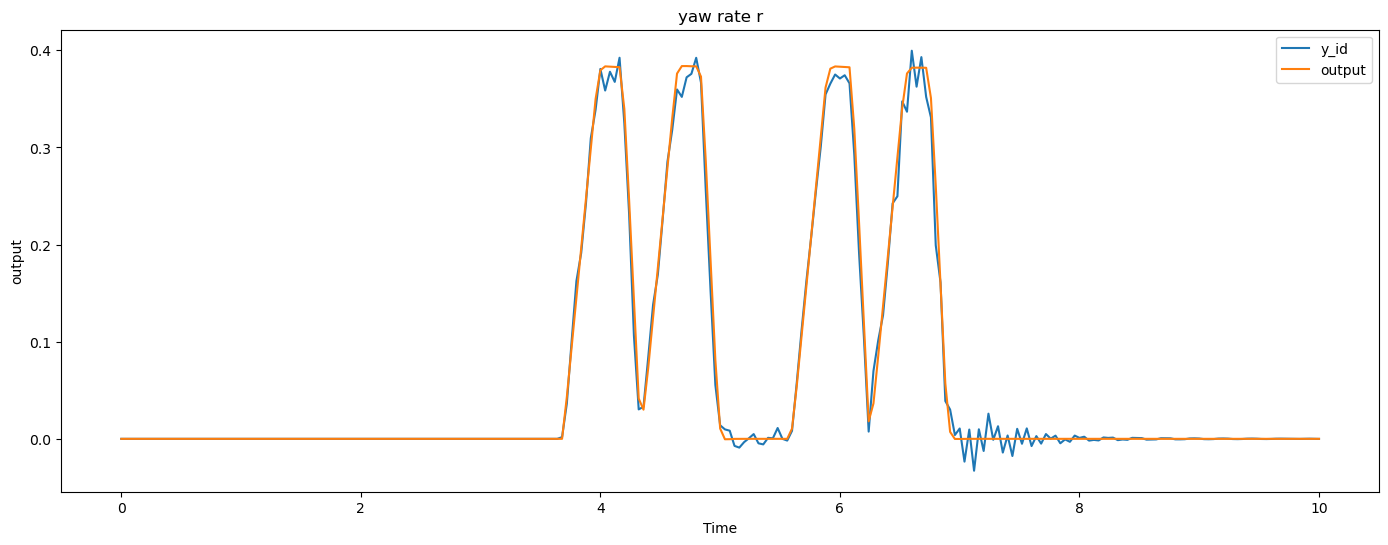

In [53]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id_circular[0],label='y_id')
plt.plot(time, outputs_circular[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

Text(0.5, 1.0, 'inertial acceleration ay')

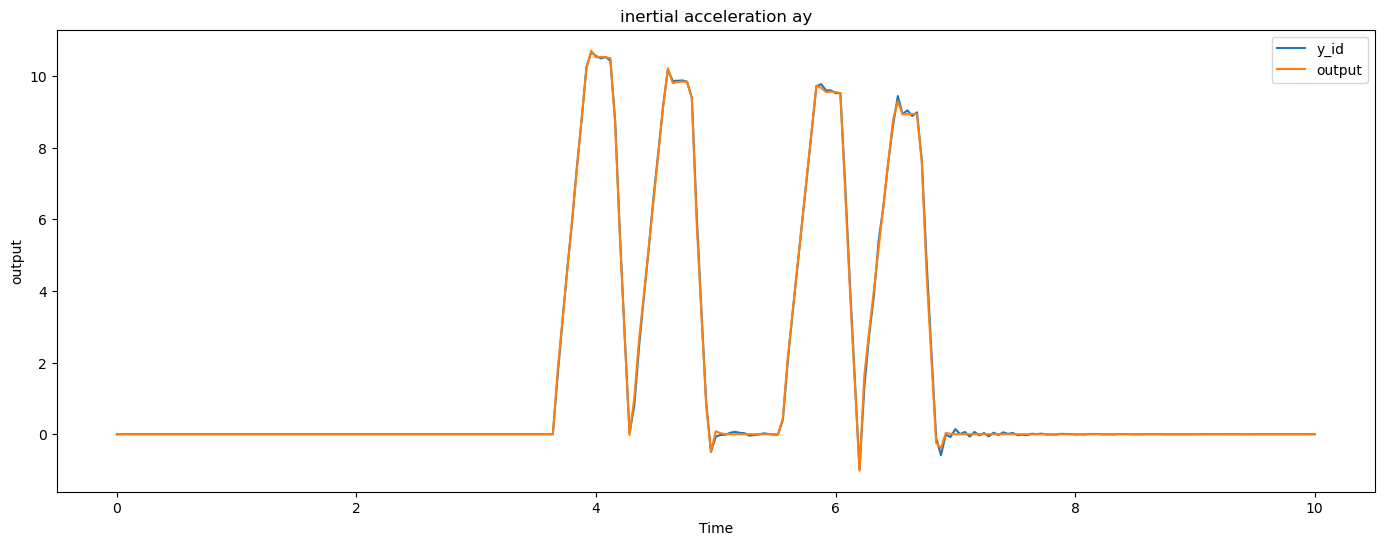

In [54]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id_circular[1], label='y_id')
plt.plot(time, outputs_circular[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [55]:
print(r2_score(outputs_circular[0], y_id_circular[0])) # r2
print(math.sqrt(mean_squared_error(outputs_circular[0], y_id_circular[0]))) #rmse

0.9932458578991806
0.01042846767205991


In [56]:
print(r2_score(outputs_circular[1], y_id_circular[1])) # r2
print(math.sqrt(mean_squared_error(outputs_circular[1], y_id_circular[1]))) # rmse

0.9996554542319399
0.0607807981254266


In [57]:
from sippy import functionset as fset

size = len(inputs[0])
noise_circular = fset.white_noise_var(size, [0.001, 0.01])

netOutput_circular = outputs_circular + noise_circular

Text(0.5, 1.0, 'yaw rate r')

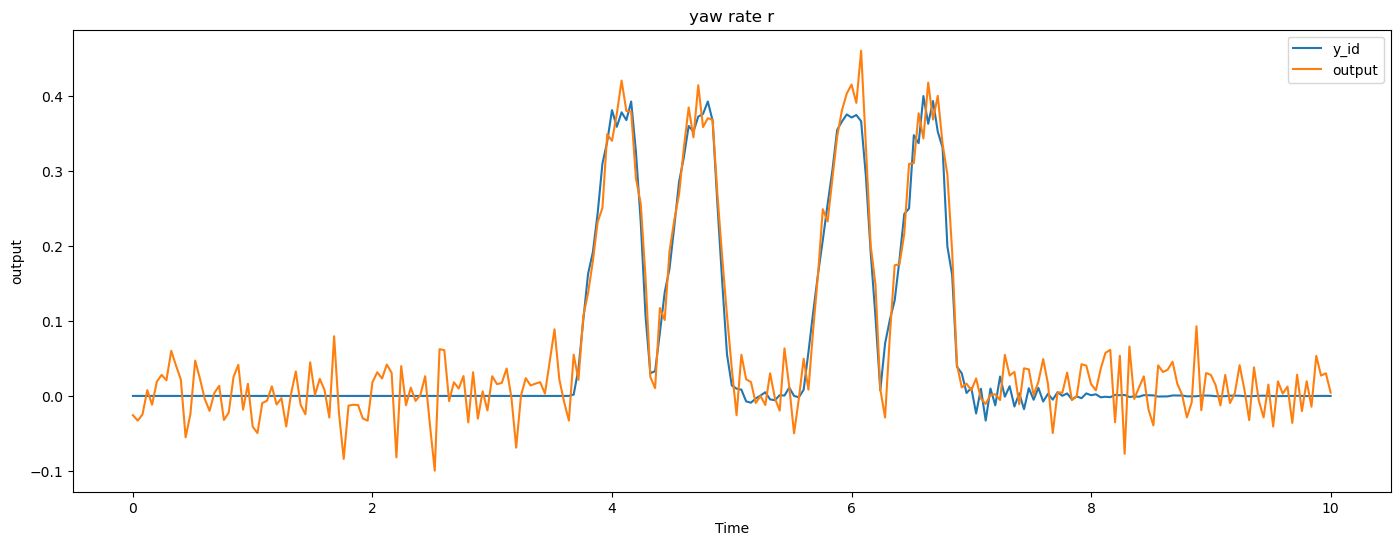

In [58]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id_circular[0],label='y_id')
plt.plot(time, netOutput_circular[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

In [59]:
print(r2_score(netOutput_circular[0], y_id_circular[0])) # r2
print(math.sqrt(mean_squared_error(netOutput_circular[0], y_id_circular[0]))) #rmse

0.9280151355490115
0.034241711767932344


Text(0.5, 1.0, 'inertial acceleration ay')

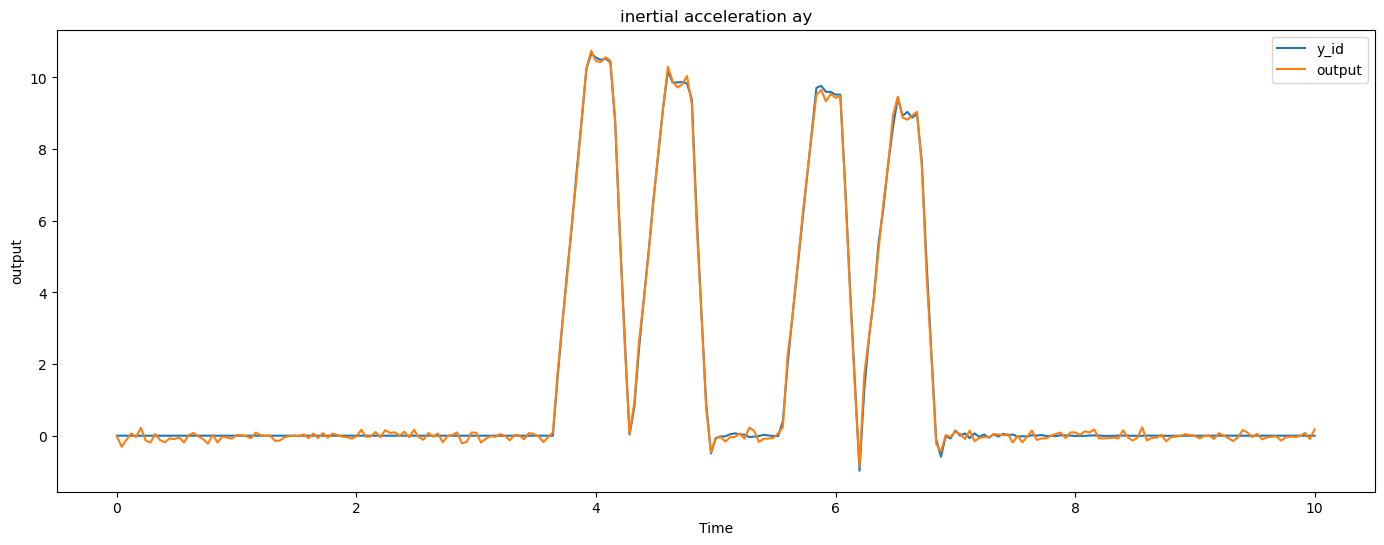

In [60]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id_circular[1], label='y_id')
plt.plot(time, netOutput_circular[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [61]:
print(r2_score(netOutput_circular[1], y_id_circular[1])) # r2
print(math.sqrt(mean_squared_error(netOutput_circular[1], y_id_circular[1]))) # rmse

0.99885150705299
0.11121666121566896


---
# VDA maneuver
---

In [62]:
vda_data = pd.read_csv('./VDA/VDA_input.csv')
vda_data.head()
# hf_data.shape

,samplingTime,Drv_DeltaSteer,Veh_Vx
0,0.000,0.0,22.222222
1,0.005,0.0,22.222032
2,0.010,0.0,22.221512
3,0.015,0.0,22.220722
4,0.020,0.0,22.219725


In [63]:
Time = vda_data['samplingTime'].to_numpy()

deltaSteer = vda_data['Drv_DeltaSteer'].to_numpy()

Vx = vda_data['Veh_Vx'].to_numpy()

n = math.floor(Ts/(Time[1]-Time[0]))

time_vda = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle_vda = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity_vda = [Vx[i] for i in range(len(Vx)) if i%n==0]

In [64]:
u_vda = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x_vda = [np.dot(np.linalg.inv(-K), u[0])]
x_cap_vda = [np.dot(np.linalg.inv(-K), u[0])]
A, B, C, D = calculate_parameters(max(Vx))
y_vda = [np.dot(C,x[0])]
y_cap_vda = [np.dot(C,x_cap[0])]

for i in range(1, len(velocity_vda)):
  A, B, C, D = calculate_parameters(velocity_vda[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y_vda[i-1] - y_cap_vda[i-1]

  x_vda.append(np.array(np.dot(out.A, x_vda[i-1])+np.dot(out.B, u_vda[i-1])))
  x_cap_vda.append(np.array(np.dot(out.A, x_vda[i-1])+np.dot(out.B, u_vda[i-1]))+np.dot(L,r))

  y_vda.append(np.dot(out.C, x_vda[i-1])+np.dot(out.D, u_vda[i-1]))
  y_cap_vda.append(np.dot(out.C, x_cap_vda[i-1])+np.dot(out.D, u_vda[i-1]))

  utemp = np.dot(-K, x_vda[i])
  utemp[0][0] += steeringAngle_vda[i]*(math.pi/180)*steering_ratio
  u_vda.append(utemp)

In [65]:
Mz_vda = []
delta_vda = []
for i in range(len(u_vda)):
    Mz_vda.append(u_vda[i][1][0])
    delta_vda.append(u_vda[i][0][0])
print(len(Mz_vda), len(delta_vda))
print(Mz_vda)
print(delta_vda)

226 226
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.7064965171616282, -16.4896282246556, -63.567320760342376, -144.09175299621293, -260.37285370524603, -414.0701526520769, -599.1832353556994, -812.2737119571218, -1051.4131184458827, -1315.0121112892882, -1602.2272515340185, -1911.9845304973956, -2373.279067643523, -3190.252212741792, -4204.664751422681, -5219.554226705748, -6218.270668507722, -7167.507263363054, -7256.563442994051, -6641.341646818929, -5962.590733481341, -5272.72924982671, -4601.82882628387, -3992.4102345794395, -3227.024347716223, -2288.419631581641, -1338.8889209059741, -395.61941388898003, 550.262070710932, 1504.38884

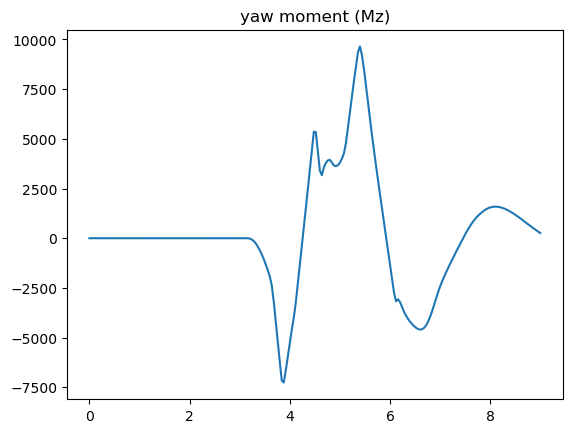

Text(0.5, 1.0, 'steering angle (delta)')

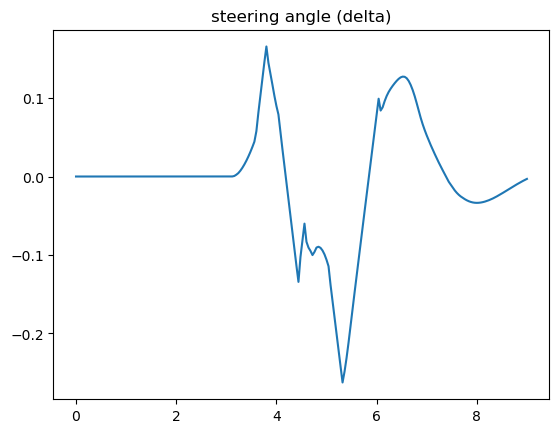

In [66]:
plt.plot(time_vda, Mz_vda)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time_vda, delta_vda)
plt.title("steering angle (delta)")

In [67]:
inputs_vda = [[], []]

for i in range(len(u_vda)):
    inputs_vda[0].append(u_vda[i][0][0])
    inputs_vda[1].append(u_vda[i][1][0])

inputs_vda = np.array(inputs_vda)

In [68]:
'''
0 -> r
1 -> ay
'''
r1_vda = []
ay_vda = []

for i in range(len(y_vda)):
    r1_vda.append(y_vda[i][0][0])
    ay_vda.append(y_vda[i][1][0])

print(len(r1_vda), len(ay_vda))
print(r1_vda)
print(ay_vda)

226 226
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025487669063683425, 0.0023135740251401726, 0.008161929579752128, 0.016942366555576304, 0.02965627951166906, 0.04586763373476513, 0.06504075659317002, 0.08692705301781749, 0.11135449725826899, 0.13818601213186593, 0.16738661939586658, 0.198840321152565, 0.25199790209229417, 0.3463650977266124, 0.4491457710133233, 0.5520829205693647, 0.6548728797984666, 0.7527230596654433, 0.7216966096268508, 0.6589262194956651, 0.5916770162910602, 0.5232857304405678, 0.45919352631236654, 0.4035348069400648, 0.31485170505847837, 0.21366558532717436, 0.11115712550103596, 0.00855233034588132, -0.09413

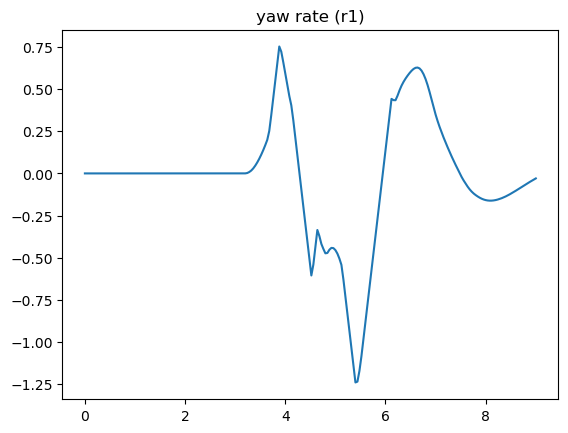

Text(0.5, 1.0, 'inertial acceleration (ay)')

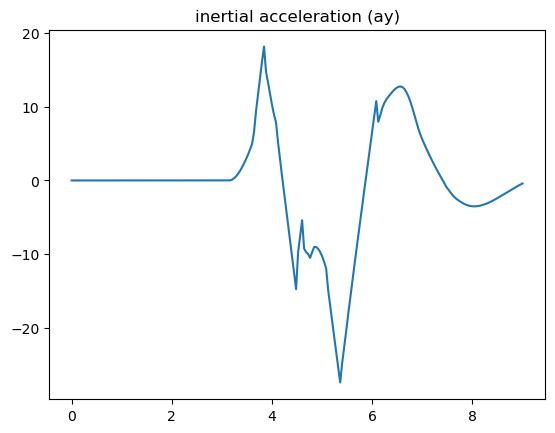

In [69]:
plt.plot(time_vda, r1_vda)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time_vda, ay_vda)
plt.title("inertial acceleration (ay)")

In [70]:
'''
0 -> r1
1 -> ay
'''
r1_cap = []
ay_cap = []

for i in range(len(y_cap)):
    r1_cap.append(y_cap[i][1][0])
    ay_cap.append(y_cap[i][0][0])

print(len(r1_cap), len(ay_cap))
print(r1_cap)
print(ay_cap)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8912587422956468, 2.481859227452582, 3.899761452290072, 5.349444770523026, 6.812798814568839, 8.276338637289205, 9.737262956884553, 11.194882724521618, 10.865803310681315, 10.921564395215642, 10.936562480045414, 10.924616622704843, 10.906456284923093, 7.316728352327922, 4.517282373752454, 1.6553052293965302, -1.231823258589701, -4.099418458532193, -6.943338785938271, -9.77100339283025, -10.800877547328415, -10.45957017795604, -10.51455316328635, -10.52007032634322, -10.490491848183204, -9.551481184600304, -7.930926381935535, -6.520086914779037, -5.0990366994441745, -3.6899437772803756, -

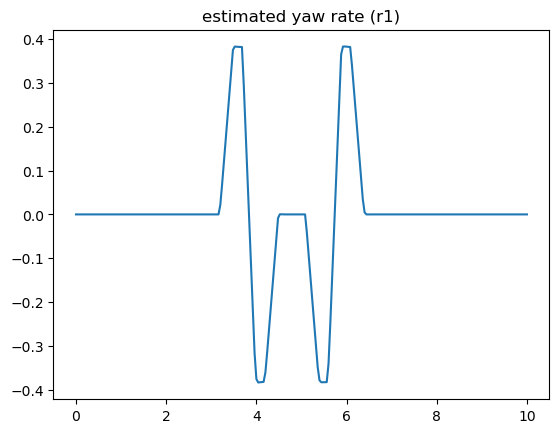

Text(0.5, 1.0, 'estimated inertial acceleration (ay)')

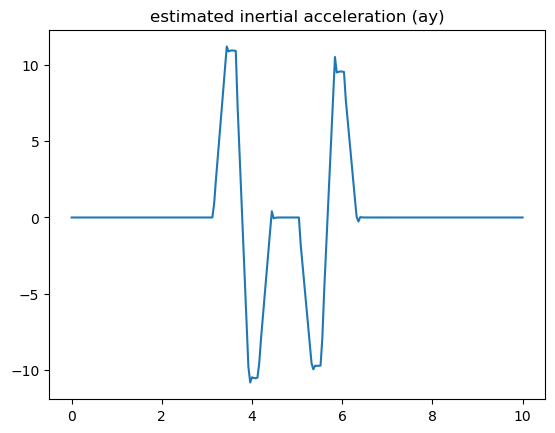

In [71]:
plt.plot(time, r1)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("estimated inertial acceleration (ay)")

In [72]:
outputs_vda = [[], []]

for i in range(len(y_vda)):
    outputs_vda[0].append(y_vda[i][0][0])
    outputs_vda[1].append(y_vda[i][1][0])

outputs_vda = np.array(outputs_vda)

In [73]:
x_id_vda, y_id_vda = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs_vda, sysId.x0)

Text(0.5, 1.0, 'yaw rate r')

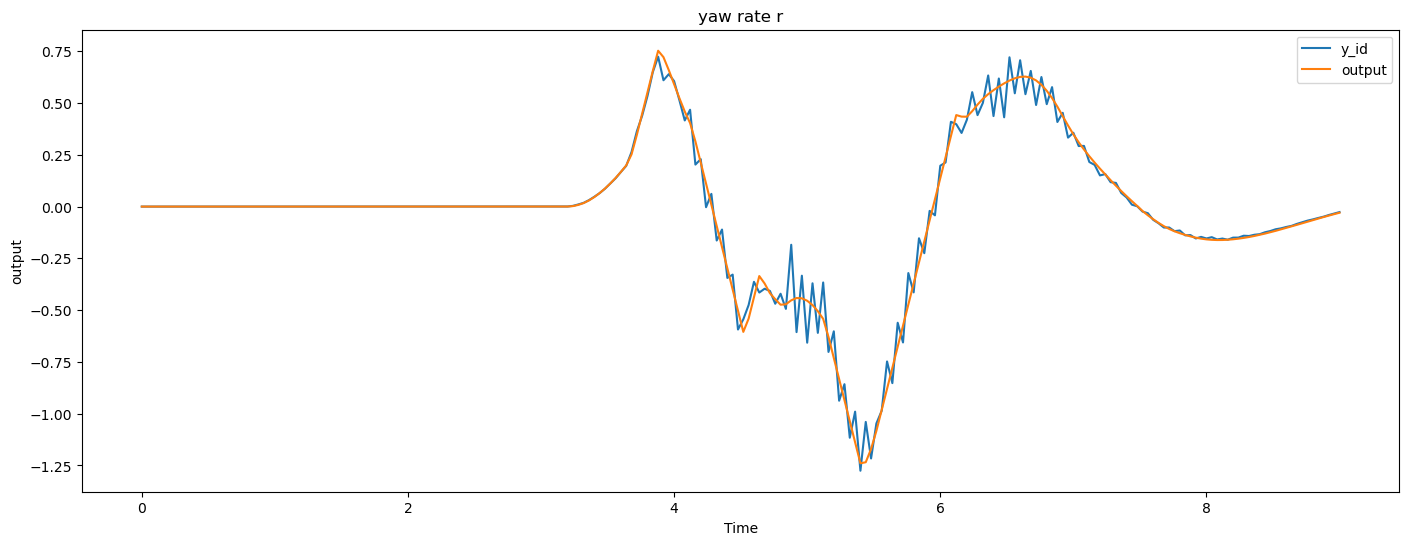

In [74]:
plt.figure(figsize=(17, 6))
plt.plot(time_vda, y_id_vda[0],label='y_id')
plt.plot(time_vda, outputs_vda[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

Text(0.5, 1.0, 'inertial acceleration ay')

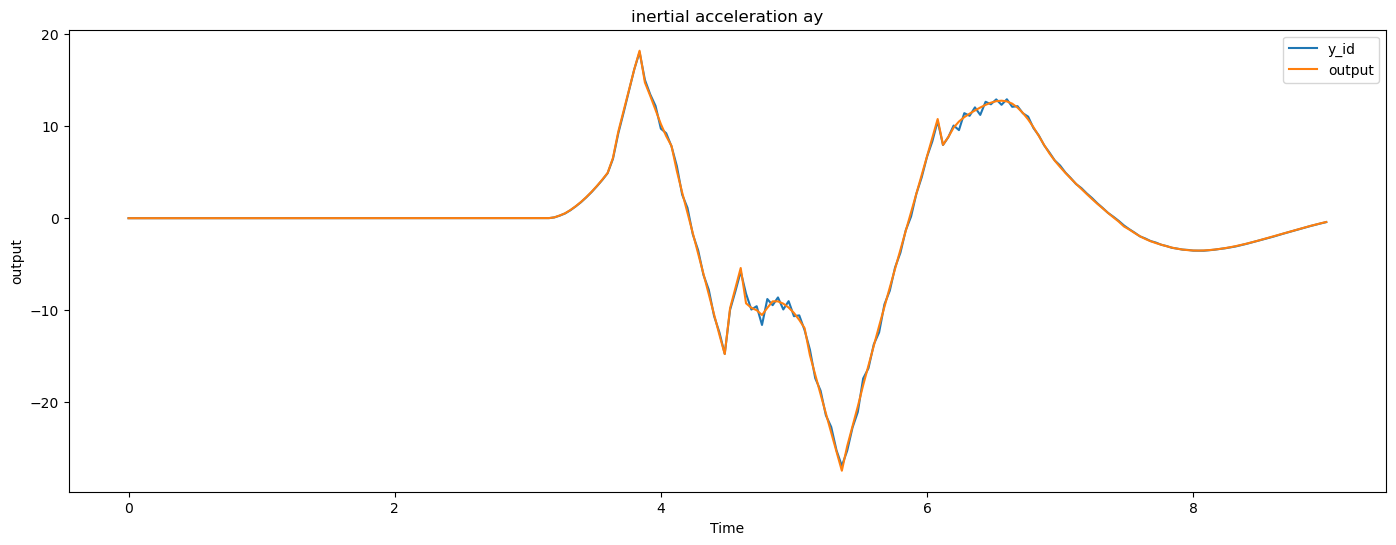

In [75]:
plt.figure(figsize=(17, 6))
plt.plot(time_vda, y_id_vda[1], label='y_id')
plt.plot(time_vda, outputs_vda[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [76]:
print(r2_score(outputs_vda[0], y_id_vda[0])) # r2
print(math.sqrt(mean_squared_error(outputs_vda[0], y_id_vda[0]))) #rmse

0.9776705031715586
0.053990947477354174


In [77]:
print(r2_score(outputs_vda[1], y_id_vda[1])) # r2
print(math.sqrt(mean_squared_error(outputs_vda[1], y_id_vda[1]))) # rmse

0.9989245100963964
0.24841341093180883


In [78]:
from sippy import functionset as fset

size = len(inputs_vda[0])
noise_vda = fset.white_noise_var(size, [0.001, 0.01])

netOutput_vda = outputs_vda + noise_vda

Text(0.5, 1.0, 'yaw rate r')

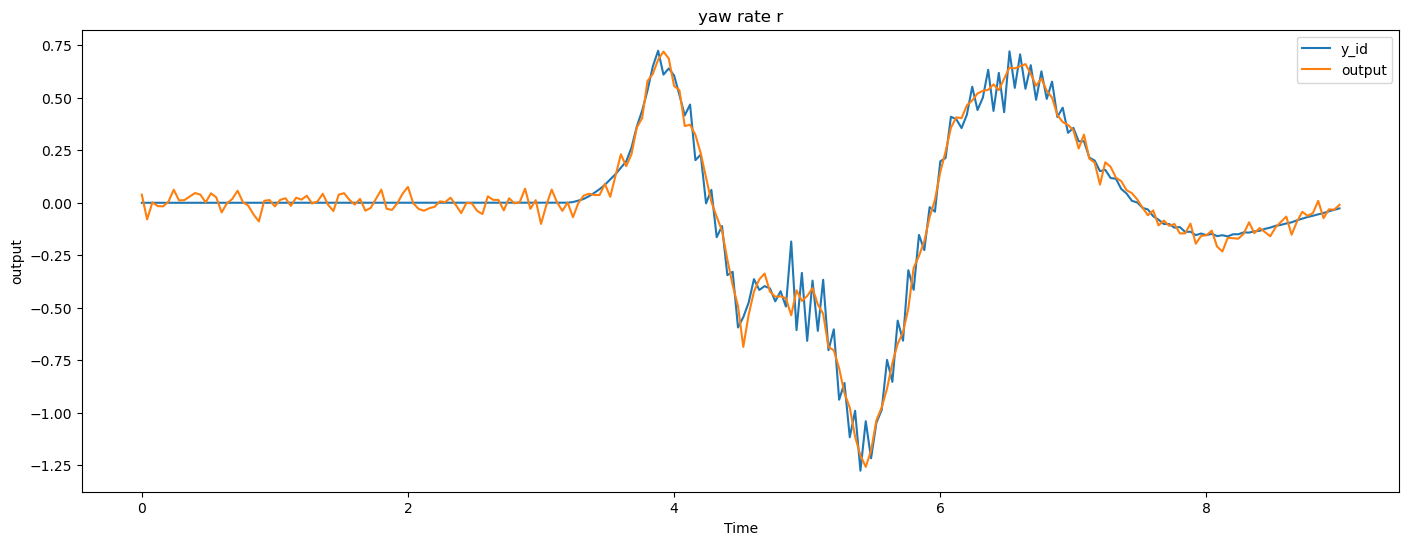

In [79]:
plt.figure(figsize=(17, 6))
plt.plot(time_vda, y_id_vda[0],label='y_id')
plt.plot(time_vda, netOutput_vda[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

In [80]:
print(r2_score(netOutput_vda[0], y_id_vda[0])) # r2
print(math.sqrt(mean_squared_error(netOutput_vda[0], y_id_vda[0]))) #rmse

0.9680306215958147
0.06390169420840199


Text(0.5, 1.0, 'inertial acceleration ay')

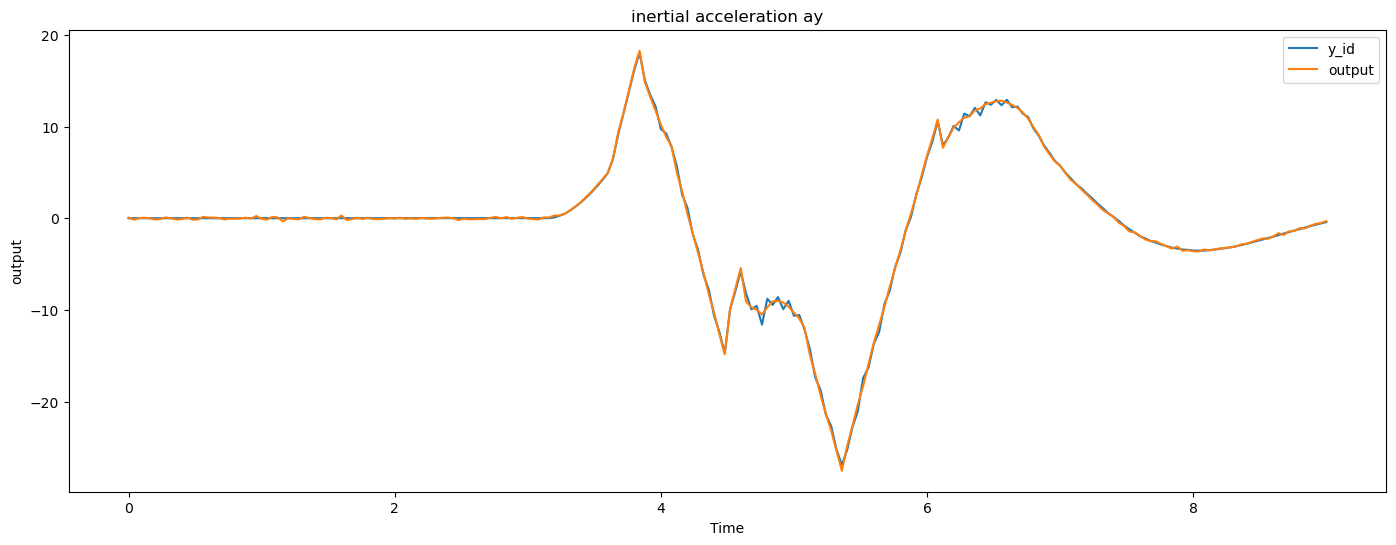

In [81]:
plt.figure(figsize=(17, 6))
plt.plot(time_vda, y_id_vda[1], label='y_id')
plt.plot(time_vda, netOutput_vda[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [82]:
print(r2_score(netOutput_vda[1], y_id_vda[1])) # r2
print(math.sqrt(mean_squared_error(netOutput_vda[1], y_id_vda[1]))) # rmse

0.9987682772214228
0.26584082907626316


---
# High Frequency
---

In [83]:
hf_data = pd.read_csv('./High frq/HighFrq_input.csv')
hf_data.head()

,Time,Drv_DeltaSteer,Veh_Vx
0,0.000,0.0,19.444444
1,0.005,0.0,19.444285
2,0.010,0.0,19.443796
3,0.015,0.0,19.443005
4,0.020,0.0,19.441990


In [84]:
# hf_data = hf_data[0:2000]
hf_data.shape

(4601, 3)

In [85]:
Time = hf_data['Time'].to_numpy()

deltaSteer = hf_data['Drv_DeltaSteer'].to_numpy()

Vx = hf_data['Veh_Vx'].to_numpy()

n = math.floor(Ts/(Time[1]-Time[0]))

time_hf = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle_hf = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity_hf = [Vx[i] for i in range(len(Vx)) if i%n==0]

In [86]:
u_hf = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x_hf = [np.dot(np.linalg.inv(-K), u_hf[0])]
x_cap_hf = [np.dot(np.linalg.inv(-K), u_hf[0])]
A, B, C, D = calculate_parameters(max(Vx))
y_hf = [np.dot(C,x_hf[0])]
y_cap_hf = [np.dot(C,x_cap_hf[0])]

for i in range(1, len(velocity_hf)):
  A, B, C, D = calculate_parameters(velocity_hf[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y_hf[i-1] - y_cap_hf[i-1]

  x_hf.append(np.array(np.dot(out.A, x_hf[i-1])+np.dot(out.B, u_hf[i-1])))
  x_cap_hf.append(np.array(np.dot(out.A, x_hf[i-1])+np.dot(out.B, u_hf[i-1]))+np.dot(L,r))

  y_hf.append(np.dot(out.C, x_hf[i-1])+np.dot(out.D, u_hf[i-1]))
  y_cap_hf.append(np.dot(out.C, x_cap_hf[i-1])+np.dot(out.D, u_hf[i-1]))

  utemp = np.dot(-K, x_hf[i])
  utemp[0][0] += steeringAngle_hf[i]*(math.pi/180)*steering_ratio
  u_hf.append(utemp)

In [87]:
Mz_hf = []
delta_hf = []
for i in range(len(u_hf)):
    Mz_hf.append(u_hf[i][1][0])
    delta_hf.append(u_hf[i][0][0])
print(len(Mz_hf), len(delta_hf))
print(Mz_hf)
print(delta_hf)

576 576
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1199.9645745010994, 1560.7494825834362, 2000.7348352305978, 1813.898642036675, 1580.1503165715662, 918.065

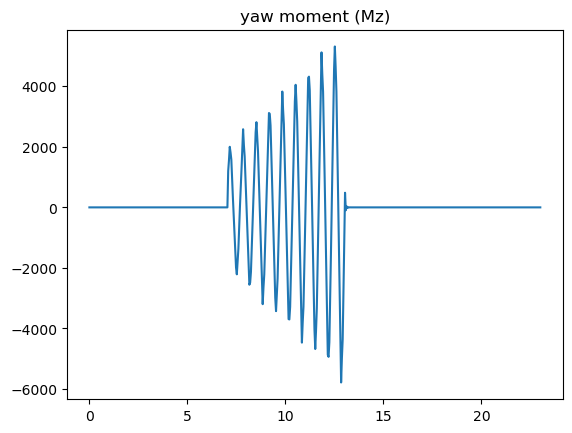

Text(0.5, 1.0, 'steering angle (delta)')

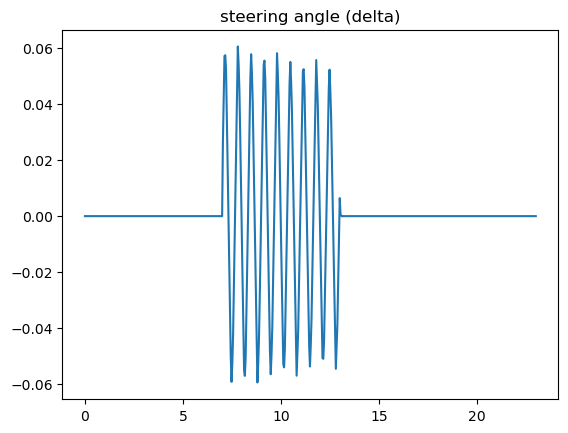

In [88]:
plt.plot(time_hf, Mz_hf)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time_hf, delta_hf)
plt.title("steering angle (delta)")

In [89]:
inputs_hf = [[], []]

for i in range(len(u_hf)):
    inputs_hf[0].append(u_hf[i][0][0])
    inputs_hf[1].append(u_hf[i][1][0])

inputs_hf = np.array(inputs_hf)

In [90]:
'''
0 -> r
1 -> ay
'''
r1_hf = []
ay_hf = []

for i in range(len(y_hf)):
    r1_hf.append(y_hf[i][0][0])
    ay_hf.append(y_hf[i][1][0])

print(len(r1_hf), len(ay_hf))
print(r1_hf)
print(ay_hf)

576 576
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07383899200690455, 0.1691930102154559, 0.2518969519348098, 0.29188720524789186, 0.2886900168233437,

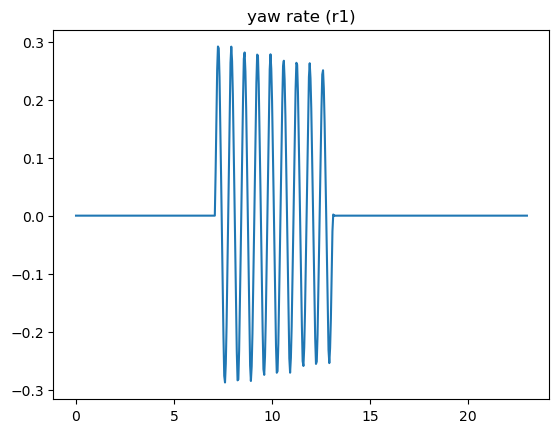

Text(0.5, 1.0, 'inertial acceleration (ay)')

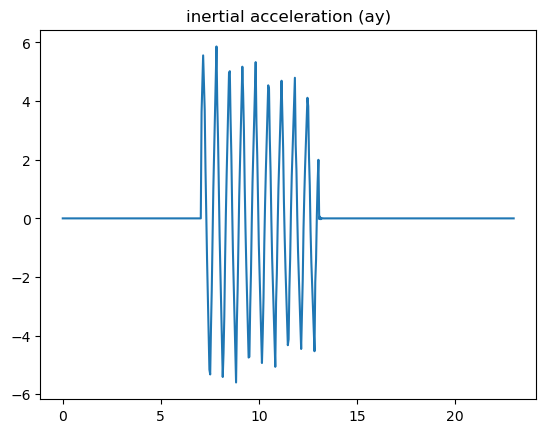

In [91]:
plt.plot(time_hf, r1_hf)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time_hf, ay_hf)
plt.title("inertial acceleration (ay)")

In [92]:
'''
0 -> r1
1 -> ay
'''
r1_cap_hf = []
ay_cap_hf = []

for i in range(len(y_cap_hf)):
    r1_cap_hf.append(y_cap_hf[i][1][0])
    ay_cap_hf.append(y_cap_hf[i][0][0])

print(len(r1_cap_hf), len(ay_cap_hf))
print(r1_cap_hf)
print(ay_cap_hf)

576 576
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.6244522186689636, 4.604179862565717, 5.558804624192359, 4.666602507507633, 3.7033854525180154, 1.6810086

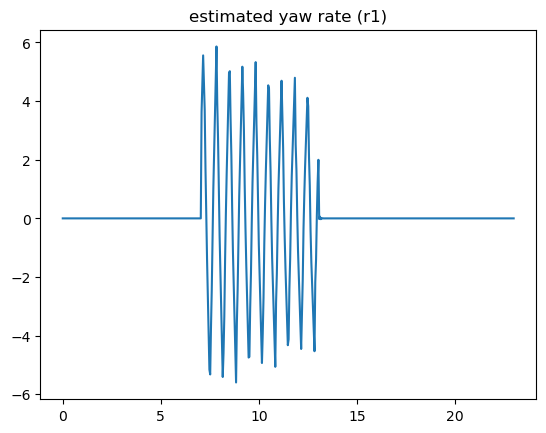

Text(0.5, 1.0, 'estimated inertial acceleration (ay)')

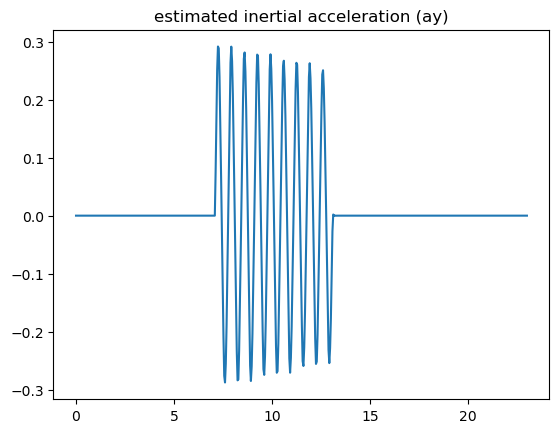

In [93]:
plt.plot(time_hf, r1_cap_hf)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time_hf, ay_cap_hf)
plt.title("estimated inertial acceleration (ay)")

In [94]:
outputs_hf = [[], []]

for i in range(len(y_hf)):
    outputs_hf[0].append(y_hf[i][0][0])
    outputs_hf[1].append(y_hf[i][1][0])

outputs_hf = np.array(outputs_hf)

In [95]:
x_id_hf, y_id_hf = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs_hf, sysId.x0)

In [105]:
sysId.A.shape

(20, 20)

Text(0.5, 1.0, 'yaw rate r')

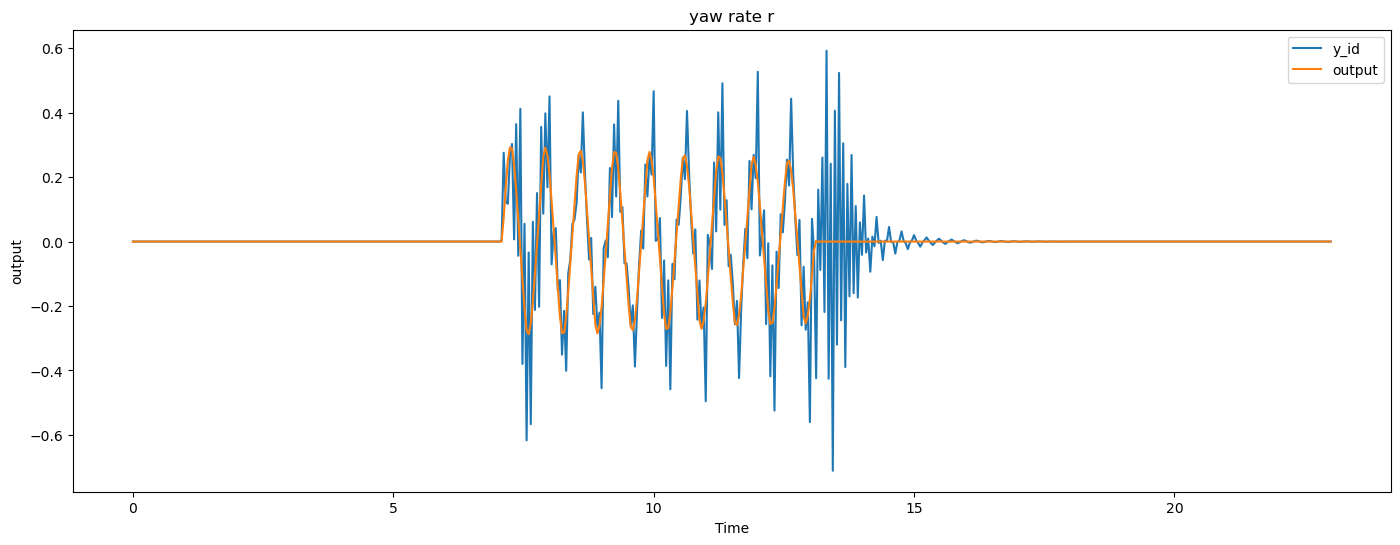

In [96]:
plt.figure(figsize=(17, 6))
plt.plot(time_hf, y_id_hf[0],label='y_id')
plt.plot(time_hf, outputs_hf[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

Text(0.5, 1.0, 'inertial acceleration ay')

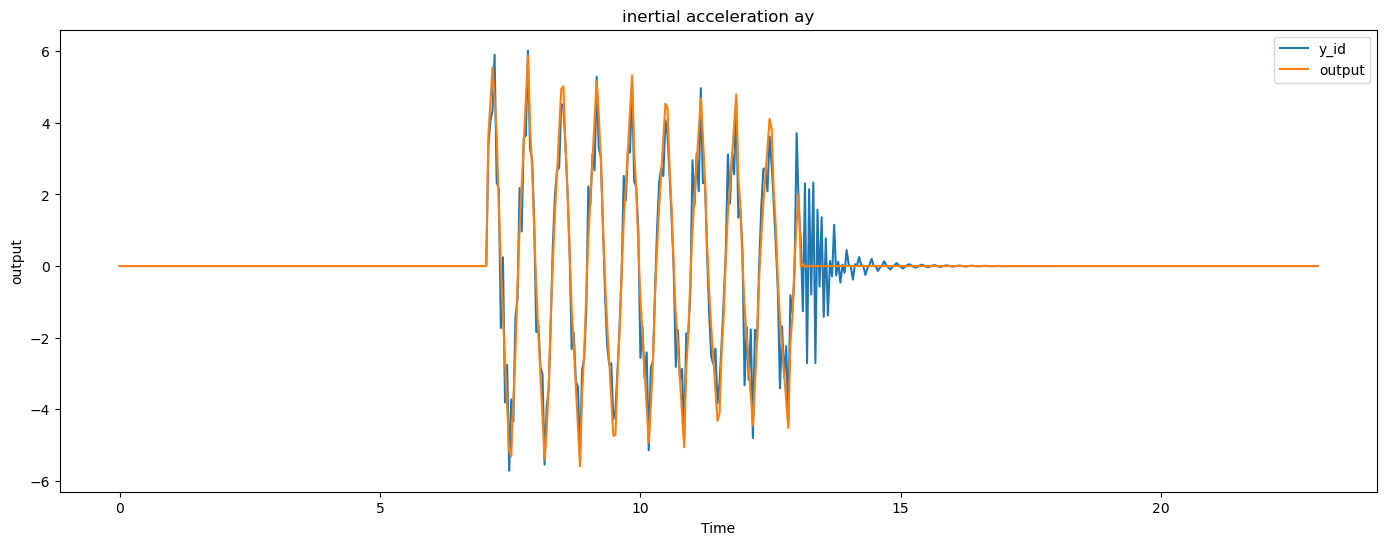

In [97]:
plt.figure(figsize=(17, 6))
plt.plot(time_hf, y_id_hf[1], label='y_id')
plt.plot(time_hf, outputs_hf[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [98]:
print(r2_score(outputs_hf[0], y_id_hf[0])) # r2
print(math.sqrt(mean_squared_error(outputs_hf[0], y_id_hf[0]))) #rmse

-0.05064518256469186
0.09778512539595162


In [99]:
print(r2_score(outputs_hf[1], y_id_hf[1])) # r2
print(math.sqrt(mean_squared_error(outputs_hf[1], y_id_hf[1]))) # rmse

0.8932667387426153
0.513297335468433


In [100]:
from sippy import functionset as fset

size = len(inputs_hf[0])
noise_hf = fset.white_noise_var(size, [0.001, 0.01])

netOutput_hf = outputs_hf + noise_hf

Text(0.5, 1.0, 'yaw rate r')

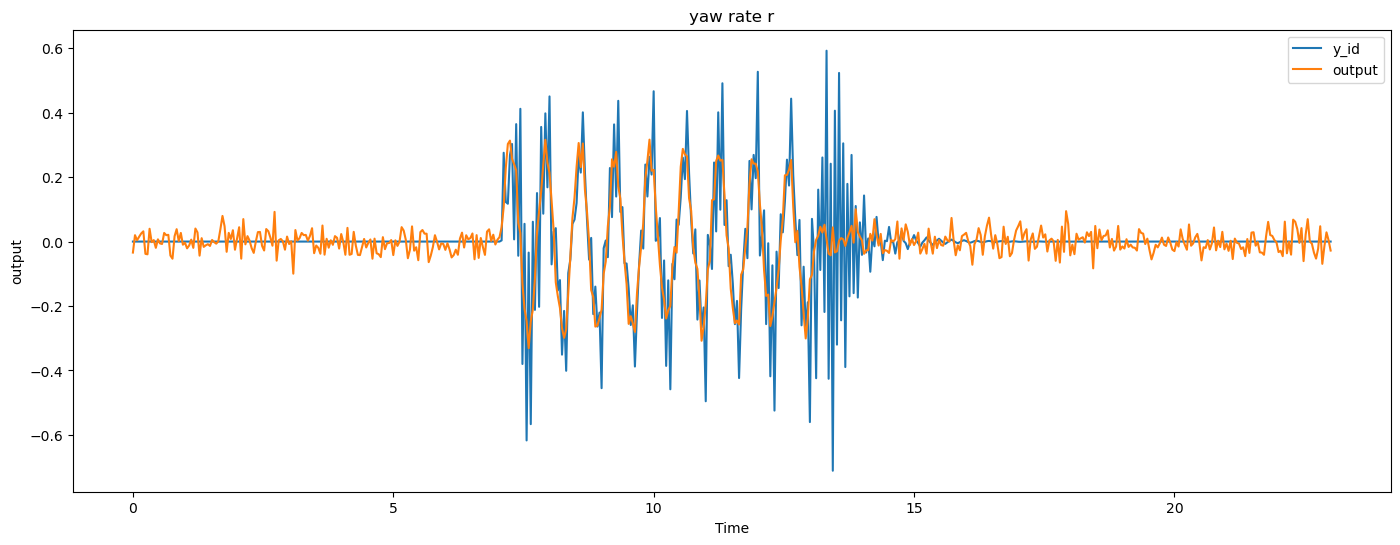

In [101]:
plt.figure(figsize=(17, 6))
plt.plot(time_hf, y_id_hf[0],label='y_id')
plt.plot(time_hf, netOutput_hf[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

In [102]:
print(r2_score(netOutput_hf[0], y_id_hf[0])) # r2
print(math.sqrt(mean_squared_error(netOutput_hf[0], y_id_hf[0]))) #rmse

-0.04633191292011518
0.10240696168778028


Text(0.5, 1.0, 'inertial acceleration ay')

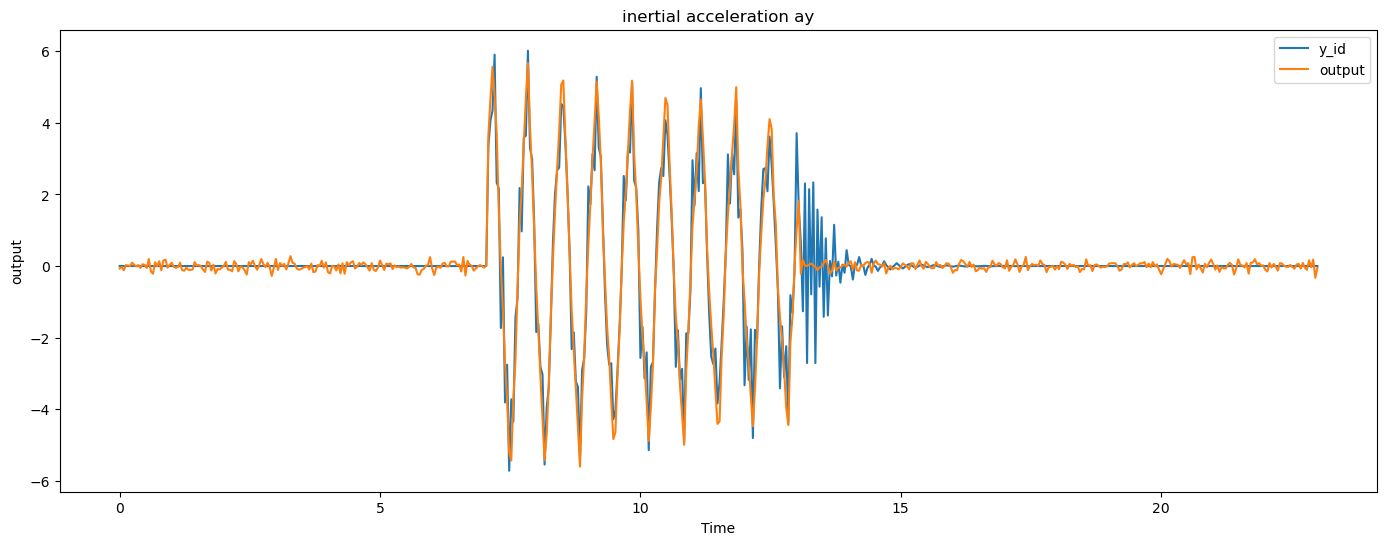

In [103]:
plt.figure(figsize=(17, 6))
plt.plot(time_hf, y_id_hf[1], label='y_id')
plt.plot(time_hf, netOutput_hf[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [104]:
print(r2_score(netOutput_hf[1], y_id_hf[1])) # r2
print(math.sqrt(mean_squared_error(netOutput_hf[1], y_id_hf[1]))) # rmse

0.8880884907020236
0.5272958232329906
